In [1]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/cxrmate-variable-tf'

device = 'cpu'

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True).to(device)
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name)
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name)

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)

/datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [22]:
# Study A:
url = 'https://www.glowm.com/resources/glowm/graphics/figures/atlases/Chest/RMLPNEUMPA_250.jpg'
response = requests.get(url)
image_1 = Image.open(BytesIO(response.content))
image_1 = image_1.convert('RGB')

url = 'https://www.glowm.com/resources/glowm/graphics/figures/atlases/Chest/RMLPNEUMLAT250.jpg'
response = requests.get(url)
image_2 = Image.open(BytesIO(response.content))
image_2 = image_2.convert('RGB')

# Study B:
url = 'https://prod-images-static.radiopaedia.org/images/566180/d527ff6fc1482161c9225345c4ab42_big_gallery.jpg'
response = requests.get(url)
image_3 = Image.open(BytesIO(response.content))
image_3 = image_3.convert('RGB')

image_1 = test_transforms(image_1)
image_2 = test_transforms(image_2)
image_3 = test_transforms(image_3)

study_a = torch.stack([image_1, image_2], dim=0)
study_b = image_3.unsqueeze(0)
dicom_study_ids = ['study_a', 'study_a', 'study_b']

# images = torch.stack([image_1, image_2, image_3], dim=0)
# images.shape

images = torch.nn.utils.rnn.pad_sequence([study_a, study_b], batch_first=True, padding_value=0.0)
images.shape

torch.Size([2, 2, 3, 384, 384])

/datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


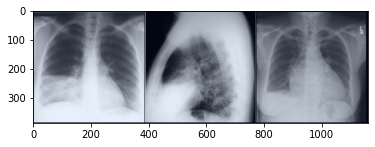

In [3]:
plt.imshow(make_grid(images, normalize=True).permute(1, 2, 0))

In [31]:
encoder_decoder.encoder(images.view(-1, *images.shape[2:]))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ /datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/torch/nn/modu │
│ les/module.py:1501 in _call_impl                                                                 │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/nic261/.cache/huggingface/modules/transformers_modules/aehrc/cxrmate-variable-tf/4cdadba54 │
│ 59d4afa85d19e099063c88844438b37/modelling_variable.py:78 in forward                              │
│                                                                                                  │
│    75 │   │   )                                                                                  │
│    76 │   │                                                                                      │
│    77 │   │   # Stack visual features from each study:                                           │
│ ❱  78 │   │   mbatch_size = len(set(dicom_study_ids))                                            │
│    79 │   │   max_images = dicom_study_ids.count(max(dicom_study_ids, key=dicom_study_ids.coun   │
│    80 │   │   feature_size = projection.shape[-1]                                                │
│    81 │   │   spatial_positions = projection.shape[-2]                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'NoneType' object is not iterable

In [16]:
num_beams = 4

bos_ids = torch.ones(
        (len(set(dicom_study_ids)), 1),
        dtype=torch.long,
        device=device,
) * tokenizer.bos_token_id

outputs = encoder_decoder.generate(
    pixel_values=images,
    decoder_input_ids=bos_ids,
    dicom_study_ids=dicom_study_ids,
    special_token_ids=[tokenizer.sep_token_id],
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256,
    num_beams=num_beams,
)

findings, impression = encoder_decoder.split_and_decode_sections(
    outputs.sequences,
    [tokenizer.sep_token_id, tokenizer.eos_token_id],
    tokenizer,
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:12                                                                                   │
│                                                                                                  │
│ /datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/torch/utils/_ │
│ contextlib.py:115 in decorate_context                                                            │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/transformers/ │
│ generation/utils.py:1322 in generate                                                             │
│                                                                                                  │
│   1319 │   │   if self.config.is_encoder_decoder and "encoder_outputs" not in model_kwargs:      │
│   1320 │   │   │   # if model is encoder decoder encoder_outputs are created                     │
│   1321 │   │   │   # and added to `model_kwargs`                                                 │
│ ❱ 1322 │   │   │   model_kwargs = self._prepare_encoder_decoder_kwargs_for_generation(           │
│   1323 │   │   │   │   inputs_tensor, model_kwargs, model_input_name                             │
│   1324 │   │   │   )                                                                             │
│   1325                                                                                           │
│                                                                                                  │
│ /datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/transformers/ │
│ generation/utils.py:638 in _prepare_encoder_decoder_kwargs_for_generation                        │
│                                                                                                  │
│    635 │   │   model_input_name = model_input_name if model_input_name is not None else self.ma  │
│    636 │   │   encoder_kwargs["return_dict"] = True                                              │
│    637 │   │   encoder_kwargs[model_input_name] = inputs_tensor                                  │
│ ❱  638 │   │   model_kwargs["encoder_outputs"]: ModelOutput = encoder(**encoder_kwargs)          │
│    639 │   │                                                                                     │
│    640 │   │   return model_kwargs                                                               │
│    641                                                                                           │
│                                                                                                  │
│ /datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/torch/nn/modu │
│ les/module.py:1501 in _call_impl                                                                 │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backwa

In [10]:
bos_ids

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

In [5]:
for i, j in zip(findings, impression):
    print(f'Findings: {i}\nImpression: {j}\n')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'findings' is not defined

In [6]:
encoder_decoder.device

device(type='cpu')